In [29]:
import sys, os
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import jax.numpy as jnp
from jax.scipy import optimize
import jax
jax.config.update("jax_enable_x64", True)
import optimistix as optx
import quadax

from jax.scipy.special import gammaincc, erf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib.network import get_network_eval_fn
from lib.trafos import transform_network_outputs, transform_network_inputs
from lib.plotting import adjust_plot_1d

from dom_track_eval import get_eval_network_doms_and_track

In [30]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [31]:
from lib.c_spe_gamma import c_multi_gamma_spe_prob
from lib.cgamma import c_multi_gamma_prob

In [32]:
convolved_spe_numeric_v1d_x = jax.jit(jax.vmap(c_multi_gamma_spe_prob, (0, None, None, None, None), 0))
convolved_spe_v1d_x = jax.jit(jax.vmap(c_multi_gamma_prob, (0, None, None, None, None), 0))

In [33]:
from jax.scipy.stats.gamma import pdf as gamma_pdf
from jax.scipy.stats.norm import pdf as norm_pdf

def c_multi_gamma_spe_prob_log(x, mix_probs, a, b, sigma=3.0):
    nmax = 3
    nint1 = 10
    nint2 = 15
    nint3 = 35
    eps = 1.e-6

    xmax = jnp.max(jnp.array([jnp.array(nmax * sigma), x + nmax * sigma]))
    diff = xmax-x
    xmin = jnp.max(jnp.array([jnp.array(0.0), x - diff]))
    x_m1 = xmin + 10
    x_m2 = x_m1 + 100

    # two combined the two integration regions
    xvals = jnp.concatenate([jnp.linspace(xmin, x_m1, nint1),
                             jnp.linspace(x_m1, x_m2, nint2),
                             jnp.linspace(x_m2, xmax, nint3)])

    dx = xvals[1:]-xvals[:-1]

    xvals = 0.5*(xvals[:-1]+xvals[1:])
    n_pdf = norm_pdf(xvals, loc=x, scale=sigma)

    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    mix_probs_e = jnp.expand_dims(mix_probs, axis=-1)

    xvals_e = jnp.expand_dims(xvals, axis=0)
    pdfs = jnp.sum(mix_probs_e * gamma_pdf(xvals_e, a_e, scale=1./b_e), axis=0)

    return jnp.sum(n_pdf * pdfs * dx)

c_multi_gamma_spe_prob_log_v1d_x = jax.vmap(c_multi_gamma_spe_prob_log, (0, None, None, None, None), 0)

In [27]:
dist = 300
z = -500
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
g_a = gamma_as
g_b = gamma_bs
sigma = 3

print(gamma_as, gamma_bs)

[ 8.34812085 10.99130109  7.4875954 ] [0.0046993  0.01011332 0.00259813]


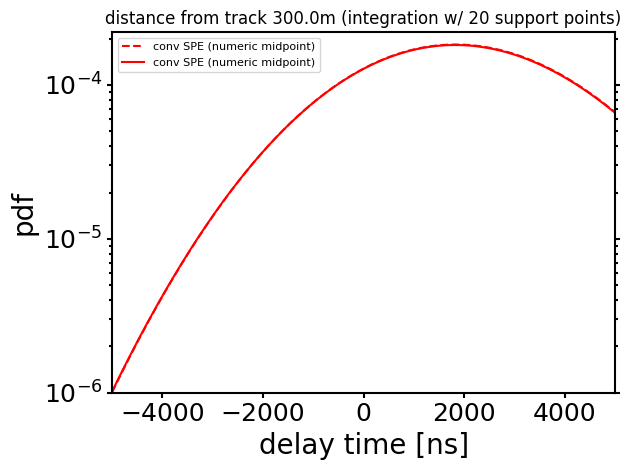

In [28]:
from matplotlib.pyplot import cm

fig, ax = plt.subplots()
xvals = np.linspace(-5000, 5000, 100000)

y_max = 0


#ys = convolved_spe_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(70.0))
#plt.plot(xvals, ys, label=f'conv SPE (hyp1f1 + approx)', color='black', linestyle='solid')
#y_max = np.amax([y_max, np.amax(ys)])

ys = convolved_spe_numeric_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(2000.0))
plt.plot(xvals, ys, label=f'conv SPE (numeric midpoint)', color='red', linestyle='dashed')
y_max = np.amax([y_max, np.amax(ys)])

ys = c_multi_gamma_spe_prob_log_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(2000.0))
plt.plot(xvals, ys, label=f'conv SPE (numeric midpoint)', color='red', linestyle='solid')
y_max = np.amax([y_max, np.amax(ys)])

plot_args = {'xlim':[-5000, 5000],
                     'ylim':[1.e-6, 1.2*y_max],
                     'xlabel':'delay time [ns]',
                     'ylabel':'pdf'}


adjust_plot_1d(fig, ax, plot_args=plot_args)

plt.yscale('log')
plt.title(f"distance from track {dist:.1f}m (integration w/ 20 support points)")
plt.tight_layout()
plt.legend(fontsize=8)
plt.show()

In [34]:
%timeit convolved_spe_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(3.0))

36.9 ms ± 126 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
%timeit convolved_spe_numeric_v1d_x(xvals, mix_probs, g_a, g_b, jnp.array(3.0))

2.67 ms ± 27.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
dx = xvals[1] - xvals[0]

In [26]:
print(jnp.sum(ys * dx))

1.0136222196815594
